<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/04.04-Lunar-Lander-Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
try: 
  import control as ct
except:
  !pip install control
  import control as ct
try:
  from lunar_lander import lunar_engine_output, lunar_control_output, lunar_update, landing_plot
except:
  # To get the file
  from requests import get
  repo_url = 'https://raw.githubusercontent.com/gmxavier/FAT0413150/main/'
  for file in ['lunar_lander.py']:
    url = repo_url+'src/'+file
    with open(file, 'w') as f: 
      f.write(get(url).text)
  # To load it and import the functions
  from lunar_lander import lunar_engine_output, lunar_control_output, lunar_update, landing_plot

# *From the Earth to the Moon*

Jules Verne described an interplanetary voyage in his 1865 novel *From the Earth to the Moon*. One hundred and four years latter, three men were sent to the moon, not in a gun-launched orbital launch vehicle, but in a rocket.

![](http://www.astronautix.com/graphics/c/csmverne.jpg)

Actually, two of these men landed another rocket (the Lunar Module) on the moon on July 20, 1969.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Scale_model_of_the_Apollo_Lunar_Module.jpg/800px-Scale_model_of_the_Apollo_Lunar_Module.jpg)

Here are some great videos about this giant leap for mankind:

- [Apollo 11 Landing on the Moon, July 20, 1969](https://youtu.be/k_OD2V6fMLQ)
- [Watch Apollo 11's Moon Landing in Amazing Simulation](https://youtu.be/T1z-Rp7nxqA)
- [Apollo 11 Landing Animation - Cockpit audio cleanup, Blender 3D, ground view, Moon, NASA](https://youtu.be/4KXAVo06nR4)

And more recently, we've seen this:

- [Falcon 9 at 10 years: Every Falcon 9/H Launch and Landing](https://youtu.be/Hc4Io1c01nU)
- [Blue Origin, November 24, 2014](https://youtu.be/9pillaOxGCo?t=103)

Inspired by these examples, and also by this amazing [notebook](https://github.com/jckantor/CBE30338/blob/master/notebooks/07.02-Soft-Landing-a-Rocket.ipynb), we start here a series of notebooks to show some basic principles of control theory using this motivational task of soft landing a rocket on the moon.

# Lunar lander dynamics

Classical control theory is hardly based on mathematical models that describe the process dynamics. To develop a simple mathematical model for the lunar lander, we will start with a force and torque balance. 

Let $p_x$ be the horizontal position, $v_x$ be the horizontal speed, $p_y$ be the vertical position, $v_y$ be the vertical speed, $\theta$ be the heading, $v_{\theta}$ be the heading speed, using Newton’s second law and the free body diagram shown below, we can derive the following equations of motion:

\begin{align*}
\frac{dp_x}{dt} & = v_x \\
\frac{dv_x}{dt} & = \frac{F_l\cos(\theta) - F_t\sin(\theta)}{m_t} \\
\frac{dp_y}{dt} & = \left\{ 
  \begin{array}{ c l }
    v_y & \quad \textrm{if } p_y \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{dv_y}{dt} & = \left\{ 
  \begin{array}{ c l }
    \frac{F_l\sin(\theta) + F_t\cos(\theta)}{m_t} - g & \quad \textrm{if } p_y \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{d\theta}{dt} & = v_\theta \\
\frac{dv_\theta}{dt} & = \frac{L}{J}F_l \\
\end{align*}

and the following auxiliary equations and constraints:

\begin{align*}
c_f & = \left\{ 
  \begin{array}{ c l }
    \frac{F_t + |F_l| }{I_{sp}} & \quad \textrm{if } p_ym_f \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{dm_t}{dt} & = -c_f \\
\frac{dm_f}{dt} & = -c_f \\
\end{align*}

\begin{align*}
0 \leq F_t \leq F_{t,max} \\
-F_{l,max} \leq F_l \leq F_{l,max} \\
\end{align*}

where $F_l$ is the lateral engine thurst, $F_t$ is the main engine thurst, $m_t$ is the total mass, $g$ is the moon's gravitional constant, $J$ the moment of inertia, $I_{sp}$ is the lateral and main engine specific impulse, $c_f$ is the fuel consumption and $m_f$ be the fuel mass.

The model parameters and initial conditions that we will use are very similar to the Lunar Module ones and are given in the following tables:

\begin{array}{|c|c|c|} \hline
\textrm{Parameter} & \textrm{Value} & \textrm{Unit} \\ \hline
g & \textrm{1.6} & m/s^2 \\
L & \textrm{4.0} & m \\
J & \textrm{100,000} & kgm^2 \\
I_{sp} & 3,000 & N/(kg/s) \\
F_{t,max} & 44,000 & N \\
F_{l,max} & 500 & N \\ \hline
\end{array}

\begin{array}{|c|c|c|} \hline
\textrm{Initial condition} & \textrm{Value} & \textrm{Unit} \\ \hline
p_x & \textrm{500} & m \\
v_x & 0 & m/s \\
p_y & \textrm{160,000} & m \\
v_y & -700 & m/s \\
\theta & 0 & rad \\
v_{\theta} & 0 & rad/s \\
m_t & 15,000 & kg \\ 
m_f & 8,000 & kg \\ \hline
\end{array}

This model was inspired on this [reference](https://web.aeromech.usyd.edu.au/AMME3500/Course_documents/material/tutorials/Assignment%204%20Lunar%20Lander%20Solution.pdf) and it is coded [here](https://github.com/gmxavier/FAT0413150/blob/main/src/lunar_lander.py).

## Input/ouput model for the lunar lander

We now create an input/output model for the lunar lander that takes the main engine throtlle $T_t$ and the lateral engine throtlle $T_l$ as inputs and outputs the horizontal position $p_x$, the horizontal speed $v_x$, the vertical position $p_y$, the vertical speed $v_y$, the heading $\theta$, the heading speed $v_\theta$, the total mass $m_t$ and the fuel mass $m_f$.



In [52]:
# To create the input/output model for the actuator
lunar_engine = ct.NonlinearIOSystem(None, 
                                    lunar_engine_output, 
                                    inputs  = ('T_t', 'T_l', 'm_t', 'p_y'), 
                                    outputs = ('F_t', 'F_l'), 
                                    name    = 'lunar_engine')

# To create an input/output model for the process
lunar_dynamics = ct.NonlinearIOSystem(lunar_update, 
                                      None, 
                                      inputs  = ('F_t', 'F_l'), 
                                      outputs = ('p_x', 'v_x', 'p_y', 'v_y', 
                                                 'theta', 'v_theta', 'm_t', 
                                                 'm_f'), 
                                      states  = ('p_x', 'v_x', 'p_y', 'v_y', 
                                                 'theta', 'v_theta', 'm_t', 
                                                 'm_f'), 
                                      name    = 'lunar_dynamics')

In [53]:
# Open loop control system
land = ct.InterconnectedSystem(
    # List of subsystems
    (lunar_engine, lunar_dynamics), name='land',

    # Interconnections between subsystems
    connections=(
        ['lunar_engine.m_t',     'lunar_dynamics.m_t'],
        ['lunar_engine.p_y',     'lunar_dynamics.p_y'],
        ['lunar_dynamics.F_t',   'lunar_engine.F_t'],
        ['lunar_dynamics.F_l',   'lunar_engine.F_l']
    ),

    # System inputs
    inplist=['lunar_engine.T_t', 'lunar_engine.T_l'],
    inputs=['T_t', 'T_l'],

    # System outputs
    outlist=['lunar_engine.T_t', 'lunar_engine.T_l', 'lunar_dynamics.p_x', 
             'lunar_dynamics.v_x', 'lunar_dynamics.p_y', 'lunar_dynamics.v_y', 
             'lunar_dynamics.theta', 'lunar_dynamics.v_theta', 
             'lunar_dynamics.m_t', 'lunar_dynamics.m_f'],
    outputs=['T_t', 'T_l', 'p_x', 'v_x', 'p_y', 'v_y', 
             'theta', 'v_theta', 'm_t', 'm_f'],
    
    # Dictionary of subsystems parameters
    params = {# Controller gains
              'K_P':  0.0e-00, # proportional gain
              'K_D':  0.0e-00  # derivative gain
              # Other parameters ...
              }
)

Next we define a function for creating a "standard" landing control plot.

In [57]:
def landing_plot(sys, T, u, x0, params):
  import numpy as np
  try: 
    import control as ct
  except:
    import pip
    package_names=['control'] # packages to install
    pip.main(['install'] + package_names)
  import control as ct
  
  v_y_max = params.get('v_y_max', 2.5) # max vertical speed [m/s]  
  
  t, y = ct.input_output_response(sys, T, u, x0, params)
  
  xlabel = 'Time $t$ [s]'
  ylabel = ['Main engine throttle $T_t$ [%]',
            'Lateral engine throttle $T_l$ [%]',
            'Horizontal position $p_x$ [km]',
            'Horizontal speed $v_x$ [m/s]',
            'Vertical position $p_y$ [km]',
            'Vertical speed $v_y$ [m/s]',
            'Heading $\\theta$ [rad]',
            'Heading speed $v_\\theta$ [rad/s]',
            'Total mass $m_t$ [Mg]',
            'Fuel mass $m_f$ [Mg]'
            ]

  res = {xlabel : t}

  fig, axes = plt.subplots(5, 2, figsize=(22, 22))
  axe = axes.ravel()

  for k, ax in enumerate(axe):
    scale = 1e3 if k in [2,4,8,9] else 1e-2 if k in [0,1] else 1
    y[k] = np.clip(y[k], 0, 1) if k in [0,1] else y[k]
    if ((k == 0) & (y[4][-1] < 0) & (-y[5][-1] < v_y_max)):
      ax.set_title('Congratulations, the lunar lander touched down at {:.1f} m/s!'.format(-y[5][-1]))
    elif ((k == 0) & (y[4][-1] < 0) & (-y[5][-1] > v_y_max)):
      ax.set_title('Sorry, the lunar lander crashed at {:.1f} m/s!'.format(-y[5][-1]))
    elif ((k == 0) & (y[4][-1] > 0)):
      ax.set_title('Sorry, the lunar lander did not touch down! Actually it is now at {:.3f} km of altitude!'.format(y[4][-1]/1e3))
    ax.plot(t, y[k]/scale)
    res[ylabel[k]] = y[k]/scale
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel[k])
    ax.grid(True, linestyle='dotted')

  return res

Let's see what happens when the crew start only the main engine at $t=14s$.

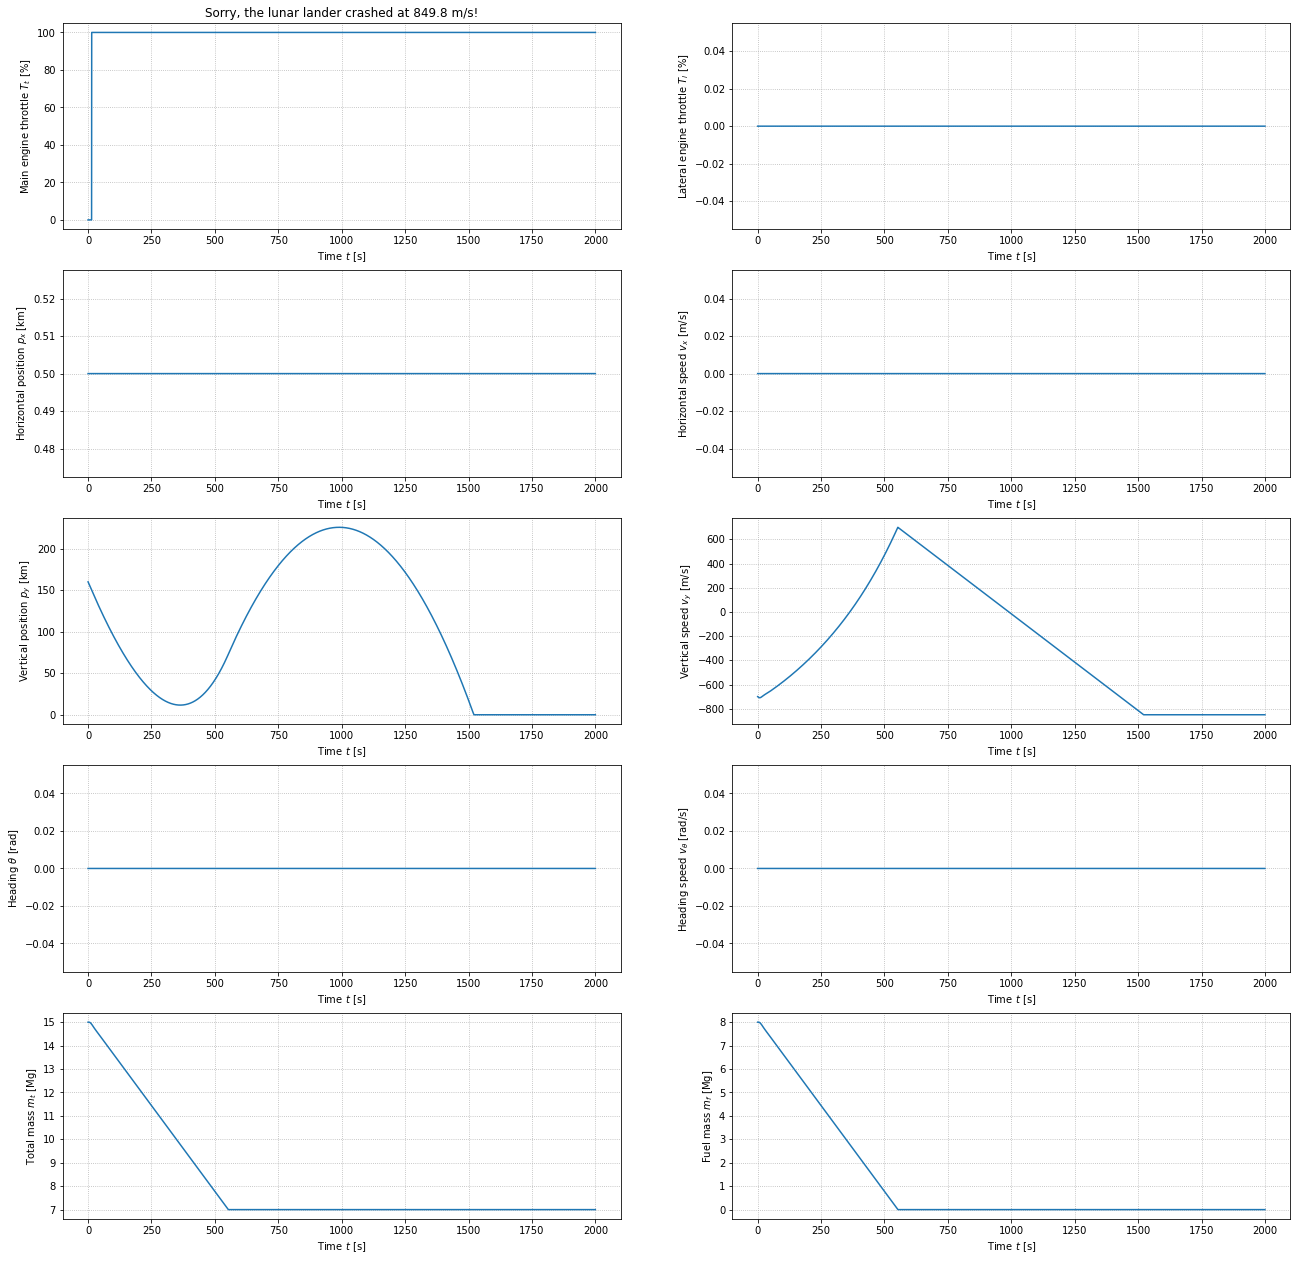

In [61]:
# Initial conditions
# p_x = 0.5 km, v_x = 0 m/s, p_y = 160 km, v_y = -0.7 km/s, theta = 0 rad, v_theta = 0 rad/s, 
x0 = [0.5e+03, 0.0, 160.0e+03, -0.7e+03, 0.0, 0.0, 15.0e+03, 8.0e+03]
# Total simulation time
Tf = 2000
# Simulation time array
T  = np.linspace(0, Tf, 10*Tf+1)
# Inputs
F_t  = np.array([44.0e+03 if (t >= 14) else 0 for t in T]) # main engine is "on" at t >= 14s
#F_t  = np.array([44.0e+03 if (t >= 14) & (t <= 400) else 0 for t in T] # main engine is "on" at 14 <= t <= 400s
F_l  = np.array(0*T) # lateral engine is "off"
# Simulate and plot
res = landing_plot(land, T, np.vstack([F_t, F_l]), x0, params={})

The plots shown that the lunar lander loosed altitude till $t \approx 375s$ and then it began to ascend (not land at all!). 

At $t \approx 500s$ the fuel is over and at $ t \approx 1,000s$ the lander reached $p_y \approx 200km$ when it starts to descend, with no thurst (the throtlle is at $100\%$, but the fuel tank is empty). 

Finally it crashes on the moon's surface at more than $800m/s$.

So, the crew was not able to soft land the lunar lander with this control strategy. 😞

Actually, they did a fatal hard land! 😱

What if we help them designing a control loop to soft land the lunar lander? Let's do it [here](https://github.com/gmxavier/FAT0413150/blob/main/notebooks/05.03-Lunar-Lander-Control.ipynb). 😀

For now, take a look on Chau's [Chapter 2](https://ia802909.us.archive.org/32/items/process-control-a-first-course-with-matlab/Process%20Control%20A%20First%20Course%20with%20MATLAB.pdf#page=22) and [Chapter 3](https://ia802909.us.archive.org/32/items/process-control-a-first-course-with-matlab/Process%20Control%20A%20First%20Course%20with%20MATLAB.pdf#page=60) and try to cast the open loop version of the land model in a transfer function form. 🍀